In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# Определение функций A(t), B(t) и f(t)
def A(t):
    return np.array([[2 * np.sin(t), -t], [t * np.exp(t), np.sqrt(t)]])

def B(t):
    return np.array([[np.sin(t), 0], [0, np.cos(t)]])

def f(t):
    return np.array([t, 2 * t])

def make_pol(xy = [], name = 'psi'):
    if np.all(xy == 0):
        return np.array([0, 0])
    else:
        if name == 'psi':
            #xy = sorted(xy, key=lambda point: point[0])
            time = np.linspace(t0, T, num_steps)
            x = [point[0] for point in xy]
            y = [point[1] for point in xy]
            psi1 = CubicSpline(time, x)
            psi2 = CubicSpline(time, y)
            return np.array([psi1, psi2])
        else:
            time = np.linspace(t0, T, num_steps)
            x = [point[0] for point in xy]
            y = [point[1] for point in xy]
            u1 = CubicSpline(time, x)
            u2 = CubicSpline(time, y)
            return np.array([u1, u2])
        
def dJ(t, psi_pol):
    #print(psi_pol)
    psi = np.array([psi_pol[0](t),psi_pol[1](t)])
    return np.dot(B(t).T, psi)
    
def abs_dJ(t, psi_pol):
    #print(psi_pol)
    res = dJ(t, psi_pol)
    return np.dot(res, res)

# Определение функции dx/dt
def dxdt(t, x, u_pol):
    if np.all(u_pol == 0):
        return np.dot(A(t), x) + f(t)
    else:
        u = np.array([u_pol[0](t), u_pol[1](t)])
        return np.dot(A(t), x) + np.dot(B(t), u) + f(t)

# Определение функции dksi/dt
def dksidt(t, ksi, pol=[]):
    return -np.dot(A(t).T, ksi)

# Метод Рунге-Кутты четвёртого порядка
def rk4(f,t, x, h, pol=[]):
    t += h
    k1 = f(t, x, pol)
    k2 = f(t + h/2, x + h*k1/2, pol)
    k3 = f(t + h/2, x + h*k2/2, pol)
    k4 = f(t + h, x + h*k3, pol)
    x_new = x + (k1 + 2*k2 + 2*k3 + k4)*h/6
    return x_new

def integral(f,psi_pol, a, b, h, n):
    #print(psi_pol)
    s = 0
    for i in range(n):
        s += f(i*h, psi_pol) * h
    return s

# Начальные условия
t0 = 0

x0 = np.array([0, 0])
N = 100
T = 1.0  # Конечное время
h = T/float(N)  # Шаг интегрирования

y = np.array([-1,1])

# Создание массивов для хранения результатов
num_steps = N
time = np.linspace(t0, T, num_steps)

X = np.zeros((num_steps, 2))
X_new = np.zeros((num_steps, 2))
psi = np.zeros((num_steps, 2))

In [3]:
# Интегрирование уравнения с помощью RK4

uk = np.zeros((num_steps, 2))
uk_new = np.zeros((num_steps, 2))
while True:
    #Решаем систему dx/dt = ...
    X[0] = x0
    x_current = x0
    u_function = make_pol(uk,'u')
    #print(u_function(0))
    for i in range(1, num_steps):
        #print(i)
        x_current = rk4(dxdt,h*i,x_current, h, u_function)
        X[i] = x_current
    #print(X[-1])
        
    # Решаем сопряженную dksi/dt = ...
    psi[-1] = 2*(X[-1] - y)
    #print(psi[-1])
    psi_current = 2*(X[-1] - y)
    for i in range(num_steps - 2, -1, -1):
        psi_current = rk4(dksidt, (1-h*i), psi_current, -h)
        psi[i] = psi_current
        #print(ksi[i])
        
    # Найдем alpha_k
    
    psi_function = make_pol(psi, 'psi')
    for i in range(num_steps):
        uk_new[i] = uk[i] - dJ(i*h, psi_function)
    #print(xy,'\n')
    #print(len(xy[0]))
    X_new[0] = x0
    x_current = x0
    u_function = make_pol(uk_new,'u')
    for i in range(num_steps):
        x_current = rk4(dxdt,h*i, x_current, h, u_function)
        X_new[i] = x_current
        
    den = np.dot(X_new[-1] - X[-1], X_new[-1] - X[-1])
    #print(psi_function)
    alpha = 0.5 * integral(abs_dJ, psi_function, t0, T, h, num_steps) / den
    
    # Найдем u_k+1
    
    for i in range(num_steps):
        uk[i] = uk[i] - alpha * dJ(i*h,psi_function)
        
        
    #print(np.dot(X[-1] - y, X[-1] - y))
    if (np.dot(X[-1] - y, X[-1] - y)) < 1e-6:
        break

#for i in range(num_steps):
    #print(f"t = {time[i]:.2f}, x = {alpha[i]}")

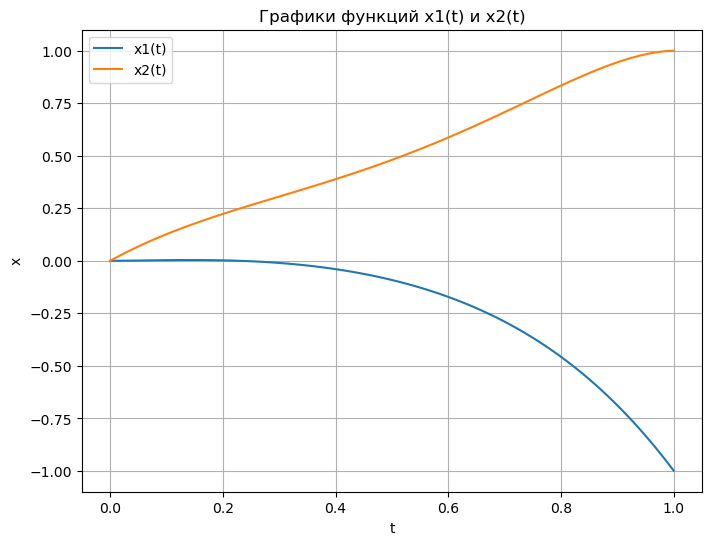

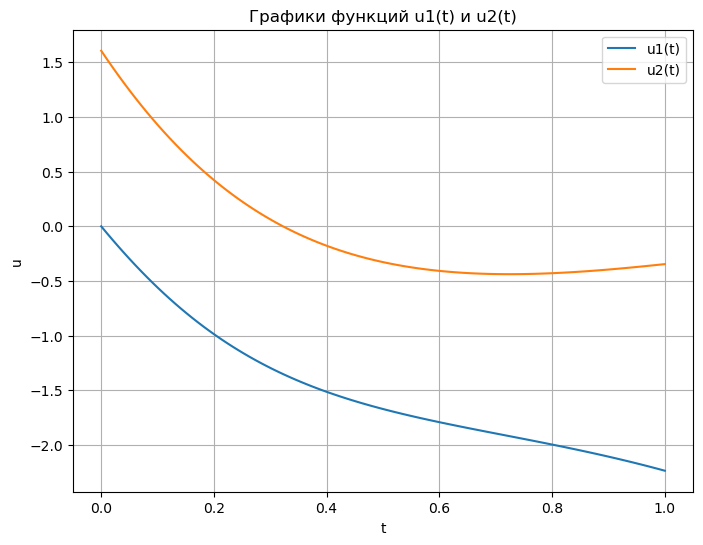

In [19]:
x1 = X[:, 0]
x2 = X[:, 1]

plt.figure(figsize=(8, 6))

plt.plot(time, x1, label='x1(t)')
plt.plot(time, x2, label='x2(t)')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Графики функций x1(t) и x2(t)')
plt.legend()

plt.grid(True)
plt.show()

u1 = uk[:, 0]
u2 = uk[:, 1]

plt.figure(figsize=(8, 6))

plt.plot(time, u1, label='u1(t)')
plt.plot(time, u2, label='u2(t)')

plt.xlabel('t')
plt.ylabel('u')
plt.title('Графики функций u1(t) и u2(t)')
plt.legend()

plt.grid(True)
plt.show()
